In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
import random

In [2]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import auc, RocCurveDisplay, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

import xgboost as xgb
from xgboost import XGBClassifier

from lightgbm import LGBMClassifier
import lightgbm

C:\Users\hmche\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



# Receiver Operating Characteristic (ROC) with cross validation

Example of Receiver Operating Characteristic (ROC) metric to evaluate
classifier output quality using cross-validation.

ROC curves typically feature true positive rate on the Y axis, and false
positive rate on the X axis. This means that the top left corner of the plot is
the "ideal" point - a false positive rate of zero, and a true positive rate of
one. This is not very realistic, but it does mean that a larger area under the
curve (AUC) is usually better.

The "steepness" of ROC curves is also important, since it is ideal to maximize
the true positive rate while minimizing the false positive rate.

This example shows the ROC response of different datasets, created from K-fold
cross-validation. Taking all of these curves, it is possible to calculate the
mean area under curve, and see the variance of the curve when the
training set is split into different subsets. This roughly shows how the
classifier output is affected by changes in the training data, and how
different the splits generated by K-fold cross-validation are from one another.

<div class="alert alert-info"><h4>Note</h4><p>See also :func:`sklearn.metrics.roc_auc_score`,
             :func:`sklearn.model_selection.cross_val_score`,
             `sphx_glr_auto_examples_model_selection_plot_roc.py`,</p></div>


2017 training -> 2021 testing

In [39]:
#df = pd.read_csv('SRER21_dataset_v1.csv', na_values='?').dropna() 
df = pd.read_csv('JORN17_dataset_v1.csv', na_values='?').dropna()
df2 = pd.read_csv('SRER21_dataset_v1.csv', na_values='?').dropna()
df3 = pd.read_csv('JORN17_dataset_v1.csv', na_values='?').dropna()
df3.isnull().sum()
df3.dropna(axis=0,inplace=True)
df= df.replace('woody',1)
df= df.replace('non-woody',0)
df2= df2.replace('woody',1)
df2= df2.replace('non-woody',0)
df3= df3.replace('woody',1)
df3= df3.replace('non-woody',0)
del df3['OID_']
del df3['Id']
del df3['gridcode']
del df3['Shape_Length']
del df3['Shape_Area']
df

,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,Veg_class
0,2,2,2,16.0,4.79,0.010000,0.223962,0.226896,0.239161,0.273236,0.274394,0.307885,0.402131,0.406066,0.427636,0.278782,0.280285,0.316995,1
1,3,3,3,8.6,2.24,0.010000,0.287822,0.287822,0.316384,0.302193,0.302193,0.305906,0.448325,0.448325,0.469259,0.301407,0.301407,0.304224,1
2,4,4,4,27.8,11.12,0.012500,0.289236,0.313074,0.459671,0.300200,0.318621,0.374641,0.447470,0.466219,0.570786,0.298798,0.314429,0.358302,1
3,5,5,5,24.2,10.62,0.060000,0.330255,0.375986,0.498250,0.313174,0.335601,0.386369,0.477596,0.517136,0.598966,0.309534,0.325886,0.368766,1
4,6,6,6,17.4,6.10,0.012000,0.275800,0.341526,0.416294,0.264112,0.280268,0.314841,0.431575,0.487791,0.518614,0.266352,0.273629,0.312146,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2696,2698,2698,2698,16.0,3.12,0.005000,0.085548,0.085548,0.098842,0.207851,0.207851,0.216101,0.296033,0.296033,0.306464,0.222759,0.222759,0.230124,1
2697,2699,2699,2699,12.0,3.45,0.020000,0.061574,0.056132,0.076203,0.196788,0.198325,0.200353,0.276355,0.274378,0.285173,0.212724,0.214114,0.215713,0
2698,2700,2700,2700,14.0,4.95,0.011429,0.195101,0.181629,0.466077,0.263570,0.256796,0.378514,0.374646,0.365065,0.561462,0.267252,0.261795,0.353228,1
2699,2701,2701,2701,24.4,8.00,0.012857,0.153912,0.123123,0.369357,0.236553,0.228040,0.354934,0.336482,0.324982,0.496476,0.240477,0.235988,0.336204,0


# Extreme Gradient Boosting

C:\Users\hmche\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\hmche\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\hmche\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\hmche\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

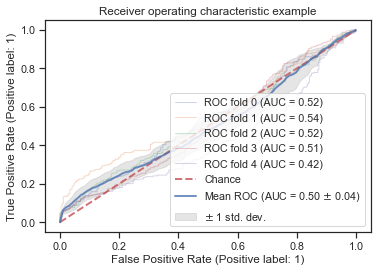


Accuracy of each fold: 
 [0.4867924528301887, 0.47358490566037736, 0.49433962264150944, 0.5320754716981132, 0.4045368620037807]
Avg accuracy: 0.47826586296679385
Std of accuracy : 
0.04167593891181152

[[366 987]
 [395 901]]

              precision    recall  f1-score   support

           0       0.48      0.27      0.35      1353
           1       0.48      0.70      0.57      1296

    accuracy                           0.48      2649
   macro avg       0.48      0.48      0.46      2649
weighted avg       0.48      0.48      0.45      2649

sens  0.270509977827051
spec  0.6952160493827161
prec  0.480946123521682
f1_score  0.34626300851466413


NameError: name 'statallfeatures_dic' is not defined

In [45]:
# #############################################################################
# Classification and ROC analysis
random.seed(1000)
# Run classifier with cross-validation and plot ROC curves
kf = KFold(n_splits=5, random_state=1, shuffle=True)
# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')
acc_score = []; 
Truth = [];
Output = [];
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(kf.split(df)):
    
    X_train , X_test = df.iloc[train_index, 5:18], df2.iloc[test_index, 5:18]
    y_train , y_test = df.iloc[train_index,-1], df2.iloc[test_index,-1]

    model.fit(X_train, y_train)
    pred_values = model.predict(X_test)
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)
    viz = RocCurveDisplay.from_estimator(
        model,
        X_test,
        y_test,
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print("sens ",sensitivity)
print("spec ", specificity)
print("prec ", precision)
print("f1_score ", f1_score)

statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['XG']=acc_score

In [ ]:
print(aucs)

# Light Gradient Boosting

In [ ]:
conda install -c conda-forge lightgbm


Accuracy of each fold: 
 [0.5377358490566038, 0.5924528301886792, 0.5377358490566038, 0.5339622641509434, 0.497164461247637]
Avg accuracy: 0.5398102507400935
Std of accuracy : 
0.030439151644785965

[[486 867]
 [352 944]]

              precision    recall  f1-score   support

           0       0.58      0.36      0.44      1353
           1       0.52      0.73      0.61      1296

    accuracy                           0.54      2649
   macro avg       0.55      0.54      0.53      2649
weighted avg       0.55      0.54      0.52      2649

sens  0.35920177383592017
spec  0.7283950617283951
prec  0.5799522673031027
f1_score  0.4436330442720219


NameError: name 'statallfeatures_dic' is not defined

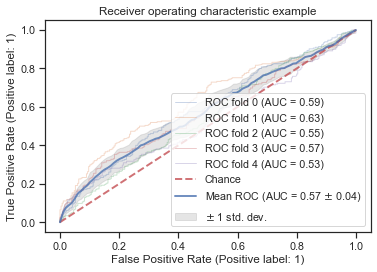

In [46]:
# #############################################################################
# Classification and ROC analysis
random.seed(1000)
# Run classifier with cross-validation and plot ROC curves
kf = KFold(n_splits=5, random_state=1, shuffle=True)
# Create the Extreme GBM
model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

acc_score = [];
Truth = [];
Output = [];
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(kf.split(df)):
    
    X_train , X_test = df.iloc[train_index,5:18], df2.iloc[test_index,5:18]
    y_train , y_test = df.iloc[train_index,-1], df2.iloc[test_index,-1]

    model.fit(X_train, y_train)
    pred_values = model.predict(X_test)
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)
    viz = RocCurveDisplay.from_estimator(
        model,
        X_test,
        y_test,
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print("sens ",sensitivity)
print("spec ", specificity)
print("prec ", precision)
print("f1_score ", f1_score)

statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

In [ ]:
print(aucs)

# CatBoosting

In [ ]:
conda install -c conda-forge catboost

In [ ]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}
indaccs_dic = {}

catboost version 1.0.6


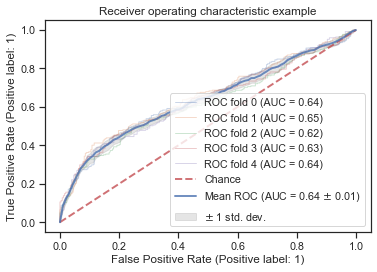


Accuracy of each fold: 
 [0.5377358490566038, 0.5584905660377358, 0.5358490566037736, 0.5452830188679245, 0.5500945179584121]
Avg accuracy: 0.5454906017048899
Std of accuracy : 
0.008286540758746996

[[472 881]
 [323 973]]

              precision    recall  f1-score   support

           0       0.59      0.35      0.44      1353
           1       0.52      0.75      0.62      1296

    accuracy                           0.55      2649
   macro avg       0.56      0.55      0.53      2649
weighted avg       0.56      0.55      0.53      2649

sens  0.34885439763488546
spec  0.7507716049382716
prec  0.5937106918238994
f1_score  0.4394785847299814


NameError: name 'statallfeatures_dic' is not defined

In [47]:
# https://catboost.ai/en/docs/concepts/python-quickstart
import catboost as cb
from catboost import CatBoostClassifier
print ('catboost version', cb.__version__)
random.seed(1000)
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
kf = KFold(n_splits=5, random_state=1, shuffle=True)
# Create CatBoost model
model = CatBoostClassifier(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                          loss_function='Logloss')
Truth = []
Output = []
tprs = []
aucs = []
acc_score = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(kf.split(df)):
    
    X_train, X_test = df.iloc[train_index,5:18], df2.iloc[test_index,5:18]
    y_train, y_test = df.iloc[train_index,-1], df2.iloc[test_index,-1]

    model.fit(X_train, y_train, verbose=False)
    pred_values = model.predict(X_test)
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

    viz = RocCurveDisplay.from_estimator(
        model,
        X_test,
        y_test,
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()


print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print("sens ",sensitivity)
print("spec ", specificity)
print("prec ", precision)
print("f1_score ", f1_score)

statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

In [ ]:
print(aucs)